In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import requests
import bs4
import time
import matplotlib.pyplot as plt
# import neo_quant


In [2]:
pd.options.display.max_rows = 60
%matplotlib inline

## open finder
!open .

## python file load
%load neo_quant.py

In [6]:
# %load neo_quant.py
import pandas as pd
import numpy as np

def make_code(x):
    x = str(x)
    return 'A' + '0' * (6-len(x)) + x


def make_code2(x):
    x = str(x)
    return '0' * (6-len(x)) + x


def get_all_company_info():
    kospi = pd.read_excel('data/kospi.xls')
    kosdaq = pd.read_excel('data/kosdaq.xls')
    kospi['구분'] = '코스피'
    kosdaq['구분'] = '코스닥'
    companies = pd.concat([kospi, kosdaq])
    companies = companies[['구분','종목코드','기업명']]
#     companies['종목코드'] = companies['종목코드'].apply(modifyCompanyCode)
    companies = companies.reset_index()
    return companies

def get_company_info(min_price):
    kospi = pd.read_excel('data/kospi.xls')
    kosdaq = pd.read_excel('data/kosdaq.xls')
    kospi['구분'] = '코스피'
    kosdaq['구분'] = '코스닥'
    companies = pd.concat([kospi, kosdaq])
    companies = companies[['종목코드','기업명','구분','액면가(원)','상장주식수(주)', '자본금(원)']]
    companies['상장주식수(주)'] = companies['상장주식수(주)'].str.replace(',','').astype(int)
    companies['자본금(원)'] = companies['자본금(원)'].str.replace(',','').astype(int)
    companies['액면가(원)'] = companies['액면가(원)'].str.replace(',','').astype(float)
    companies = companies[companies['액면가(원)'] >= min_price]
    companies['액면가(원)'] = companies['액면가(원)'].astype(int)
    companies = companies.set_index('종목코드')
    return companies

def company_apply_a_prefix(companies):
    old_index = pd.Series(companies.index)
    new_index = old_index.map(make_code)
    return companies.set_index(new_index)

def company_apply_no_prefix(companies):
    old_index = pd.Series(companies.index)
    new_index = old_index.map(make_code2)
    return companies.set_index(new_index)

# 액면가 1000원 이상 회사 리스트 가져와서 코드앞에 A 붙이기
# companies = get_company_info(1000)
# companies = apply_a_type_code(companies)

def filter_company(st_df, companies):
    new_company_list = []
    for num, code in enumerate(st_df.index):
        if code in companies.index:
            new_company_list.append(code)

    return st_df.loc[new_company_list]

def add_company_info(st_df, companies):
    return pd.merge(st_df, companies, how='inner', left_index=True, right_index=True)

# 데이터프레임에서 회사코드로 필터링한 후 회사 정보 추가하기
# roa_filter_info = add_company_info(filter_company(roa, companies), companies)

def get_kospi_list(st_df):
    return st_df[st_df['구분']=='코스피']

def get_kosdaq_list(st_df):
    return st_df[st_df['구분']=='코스닥']

def get_price_over_list(st_df, price):
    return st_df[st_df['액면가(원)'] >= price]


# [코드 3.15] 재무제표 데이터를 가져와 데이터프레임으로 만드는 함수 (CH3. 데이터 수집하기.ipynb)

def make_fs_dataframe(firm_code):
    fs_url = 'https://comp.fnguide.com/SVO2/asp/SVD_Finance.asp?pGB=1&cID=&MenuYn=Y&ReportGB=D&NewMenuID=103&stkGb=701&gicode=' + firm_code
    fs_page = requests.get(fs_url)
    fs_tables = pd.read_html(fs_page.text)
    
    temp_df = fs_tables[0]
    temp_df = temp_df.set_index(temp_df.columns[0])
    temp_df = temp_df[temp_df.columns[:4]]
    temp_df = temp_df.loc[['매출액', '영업이익', '당기순이익']]

    temp_df2 = fs_tables[2]
    temp_df2 = temp_df2.set_index(temp_df2.columns[0])
    temp_df2 = temp_df2.loc[['자산', '부채', '자본']]

    temp_df3 = fs_tables[4]
    temp_df3 = temp_df3.set_index(temp_df3.columns[0])
    temp_df3 = temp_df3.loc[['영업활동으로인한현금흐름']]

    fs_df = pd.concat([temp_df, temp_df2, temp_df3])
    
    return fs_df

# [코드 3.19] 데이터프레임 형태 바꾸기 코드 함수화 (CH3. 데이터 수집하기.ipynb)

def change_df(firm_code, dataframe):
    for num, col in enumerate(dataframe.columns):
        temp_df = pd.DataFrame({firm_code : dataframe[col]})
        temp_df = temp_df.T
        temp_df.columns = [[col]*len(dataframe), temp_df.columns]
        if num == 0:
            total_df = temp_df
        else:
            total_df = pd.merge(total_df, temp_df, how='outer', left_index=True, right_index=True)    
    
    return total_df

# [코드 3.21] 재무 비율 데이터프레임을 만드는 함수 (CH3. 데이터 수집하기.ipynb)

def make_fr_dataframe(firm_code):
    fr_url = 'https://comp.fnguide.com/SVO2/asp/SVD_FinanceRatio.asp?pGB=1&cID=&MenuYn=Y&ReportGB=D&NewMenuID=104&stkGb=701&gicode=' + firm_code
    fr_page = requests.get(fr_url)
    fr_tables = pd.read_html(fr_page.text)
    
    temp_df = fr_tables[0]
    temp_df = temp_df.set_index(temp_df.columns[0])
    temp_df = temp_df.loc[['유동비율계산에 참여한 계정 펼치기',
                           '부채비율계산에 참여한 계정 펼치기',
                           '영업이익증가율계산에 참여한 계정 펼치기',
                           'ROA계산에 참여한 계정 펼치기',
                           'ROIC계산에 참여한 계정 펼치기']]
    temp_df.index = ['유동비율', '부채비율', '영업이익률', 'ROA', 'ROIC']
    return temp_df

# [코드 3.23] 투자지표 데이터프레임을 만드는 함수 (CH3. 데이터 수집하기.ipynb)

def make_invest_dataframe(firm_code):
    invest_url = 'https://comp.fnguide.com/SVO2/asp/SVD_Invest.asp?pGB=1&cID=&MenuYn=Y&ReportGB=D&NewMenuID=105&stkGb=701&gicode=' + firm_code
    invest_page = requests.get(invest_url)
    invest_tables = pd.read_html(invest_page.text)
    temp_df = invest_tables[1]
    
    temp_df = temp_df.set_index(temp_df.columns[0])
    temp_df = temp_df.loc[['PER계산에 참여한 계정 펼치기',
                       'PCR계산에 참여한 계정 펼치기',
                       'PSR계산에 참여한 계정 펼치기',
                       'PBR계산에 참여한 계정 펼치기',
                      '총현금흐름']]
    temp_df.index = ['PER', 'PCR', 'PSR', 'PBR', '총현금흐름']
    return temp_df

#  [코드 3.40] 가격을 가져와 데이터프레임 만드는 함수 (CH3. 데이터 수집하기 2.ipynb)

def make_price_dataframe(code, timeframe, count):
    url = 'https://fchart.stock.naver.com/sise.nhn?requestType=0'
    price_url = url + '&symbol=' + code + '&timeframe=' + timeframe + '&count=' + count
    price_data = requests.get(price_url)
    price_data_bs = bs4.BeautifulSoup(price_data.text, 'lxml')
    item_list = price_data_bs.find_all('item')
    
    date_list = []
    price_list = []
    for item in item_list:
        temp_data = item['data']
        datas = temp_data.split('|')
        date_list.append(datas[0])
        price_list.append(datas[4])

    price_df = pd.DataFrame({code:price_list}, index=date_list)
    
    return price_df

#  [코드 4.6] 재무 데이터 전처리하는 함수 (CH4. 전략 구현하기.ipynb)

def get_finance_data(path):
    data_path = path
    raw_data = pd.read_excel(data_path)
    raw_data = raw_data.set_index(raw_data.columns[0])
    big_col = list(raw_data.columns)
    small_col = list(raw_data.iloc[0])
    
    new_big_col = []
    for num, col in enumerate(big_col):
        if 'Unnamed' in col:
            new_big_col.append(new_big_col[num-1])
        else:
            new_big_col.append(big_col[num])
            
    raw_data.columns = [new_big_col, small_col]
    clean_df = raw_data.loc[ raw_data.index.dropna() ]
    
    return clean_df

def check_IFRS(x):
    if x == 'N/A(IFRS)':
        return np.NaN
    else:
        return x

#  [코드 4.14] PER기준으로 오름차순으로 정렬하여 주는 함수 (CH4. 전략 구현하기.ipynb)

def low_per(invest_df, index_date, num):
    invest_df[(index_date, 'PER')] = pd.to_numeric(invest_df[(index_date, 'PER')])
    per_sorted = invest_df.sort_values(by=(index_date, 'PER'))
    return per_sorted[index_date][:num]

#  [코드 4.15] ROA기준으로 내림차순으로 정렬하여 주는 함수 (CH4. 전략 구현하기.ipynb)

def high_roa(fr_df, index_date, num):
    fr_df[(index_date, 'ROA')] = fr_df[(index_date, 'ROA')].apply(check_IFRS)
    fr_df[(index_date, 'ROA')] = pd.to_numeric(fr_df[(index_date, 'ROA')] )
    sorted_roa = fr_df.sort_values(by=(index_date, 'ROA'), ascending=False)
    return sorted_roa[index_date][:num]


#  [코드 4.22] 마법공식 함수로 만들기 (CH4. 전략 구현하기.ipynb)

def magic_formula(fr_df, invest_df, index_date, num):
    per = low_per(invest_df, index_date, None)
    roa = high_roa(fr_df, index_date, None)
    per['per순위'] = per['PER'].rank()
    roa['roa순위'] = roa['ROA'].rank(ascending=False)
    magic = pd.merge(per, roa, how='outer', left_index=True, right_index=True)
    magic['마법공식 순위'] = (magic['per순위'] + magic['roa순위']).rank().sort_values()
    magic = magic.sort_values(by='마법공식 순위')
    return magic[:num]

#  [코드 4.23] 저평가 지수를 기준으로 정렬하여 순위 만들어 주는 함수 (CH4. 전략 구현하기.ipynb)

def get_value_rank(invest_df, value_type, index_date, num):
    invest_df[(index_date,  value_type)] = pd.to_numeric(invest_df[(index_date,  value_type)])
    value_sorted = invest_df.sort_values(by=(index_date,  value_type))[index_date]
    value_sorted[  value_type + '순위'] = value_sorted[value_type].rank()
    return value_sorted[[value_type, value_type + '순위']][:num]

#  [코드 4.25] 저평가 지표 조합 함수 (CH4. 전략 구현하기.ipynb)

def make_value_combo(value_list, invest_df, index_date, num):
    
    for i, value in enumerate(value_list):
        temp_df = get_value_rank(invest_df, value, index_date, None)
        if i == 0:
            value_combo_df = temp_df
            rank_combo = temp_df[value + '순위']
        else:
            value_combo_df = pd.merge(value_combo_df, temp_df, how='outer', left_index=True, right_index=True)
            rank_combo = rank_combo + temp_df[value + '순위']
    
    value_combo_df['종합순위'] = rank_combo.rank()
    value_combo_df = value_combo_df.sort_values(by='종합순위')
    
    return value_combo_df[:num]

#  [코드 4.29] F-score 함수(CH4. 전략 구현하기.ipynb)

def get_fscore(fs_df, index_date, num):
    fscore_df = fs_df[index_date]
    fscore_df['당기순이익점수'] = fscore_df['당기순이익'] > 0
    fscore_df['영업활동점수'] = fscore_df['영업활동으로인한현금흐름'] > 0
    fscore_df['더큰영업활동점수'] = fscore_df['영업활동으로인한현금흐름'] > fscore_df['당기순이익']
    fscore_df['종합점수'] = fscore_df[['당기순이익점수', '영업활동점수', '더큰영업활동점수']].sum(axis=1)
    fscore_df = fscore_df[fscore_df['종합점수'] == 3]
    return fscore_df[:num]

#  [코드 4.34] 모멘텀 데이터프레임 만들기 함수화 (CH4. 전략 구현하기.ipynb)

def get_momentum_rank(price_df, index_date, date_range, num):
    momentum_df = pd.DataFrame(price_df.pct_change(date_range).loc[index_date])
    momentum_df.columns = ['모멘텀']
    momentum_df['모멘텀순위'] = momentum_df['모멘텀'].rank(ascending=False)
    momentum_df = momentum_df.sort_values(by='모멘텀순위')
    return momentum_df[:num]

#  [코드 4.39] 저평가 + Fscore 함수화 (CH4. 전략 구현하기.ipynb)

def get_value_quality(invest_df, fs_df, index_date, num):
    value = make_value_combo(['PER', 'PBR', 'PSR', 'PCR'], invest_df, index_date, None)
    quality = get_fscore(fs_df, index_date, None)
    value_quality = pd.merge(value, quality, how='outer', left_index=True, right_index=True)
    value_quality_filtered = value_quality[value_quality['종합점수'] == 3]
    vq_df = value_quality_filtered.sort_values(by='종합순위')
    return vq_df[:num]

#  [코드 5.12] 백테스트 함수 버젼1 (Ch5. 백테스트.ipynb)


def backtest_beta(price_df, strategy_df, start_date, end_date, initial_money):

    code_list = []
    for code in strategy_df.index:
        code_list.append(code.replace('A',''))

    strategy_price = price_df[code_list][start_date:end_date]

    pf_stock_num = {}
    stock_amount = 0
    stock_pf = 0
    each_money = initial_money / len(strategy_df)
    for code in strategy_price.columns:
        temp = int( each_money / strategy_price[code][0] )
        pf_stock_num[code] = temp
        stock_amount = stock_amount + temp * strategy_price[code][0]
        stock_pf = stock_pf + strategy_price[code] * pf_stock_num[code]

    cash_amount = initial_money - stock_amount

    backtest_df = pd.DataFrame({'주식포트폴리오':stock_pf})
    backtest_df['현금포트폴리오'] = [cash_amount] * len(backtest_df)
    backtest_df['종합포트폴리오'] = backtest_df['주식포트폴리오'] + backtest_df['현금포트폴리오']
    backtest_df['일변화율'] = backtest_df['종합포트폴리오'].pct_change()
    backtest_df['총변화율'] = backtest_df['종합포트폴리오']/initial_money - 1
    
    return backtest_df

#  [코드 5.16] 해당 날짜에 가격이 없으면 투자 관련 데이터에서 해당 종목 없애는 함수 (Ch5. 백테스트.ipynb)

def select_code_by_price(price_df, data_df, start_date):
    new_code_list = []
    for code in price_df[start_date].iloc[0].dropna().index:
        new_code_list.append('A' + code)
        
    selected_df =  data_df.loc[new_code_list]
    return selected_df

# [코드 5.24] 백테스트 시작날짜가 주어지면 전략 기준 날짜를 계산하는 함수 (Ch5. 백테스트.ipynb)

def get_strategy_date(start_date):
    temp_year = int(start_date.split('-')[0])
    temp_month = start_date.split('-')[1]
    if temp_month in '1 2 3 4 5'.split(' '):
        strategy_date = str(temp_year - 2) + '/12'
    else:
        strategy_date = str(temp_year - 1) + '/12'
    return strategy_date


# [코드 5.32] 리밸런싱 백테스트 함수화 (Ch5. 백테스트.ipynb)

def backtest_re(strategy, start_date, end_date, initial_money, price_df, fr_df, fs_df, num, value_type=None, value_list=None, date_range=None):
    
    start_year = int(start_date.split('-')[0])
    end_year = int(end_date.split('-')[0])

    total_df = 0
    for temp in range(start_year, end_year):
        this_term_start = str(temp) + '-' + start_date.split('-')[1]
        this_term_end = str(temp+1) + '-' + start_date.split('-')[1]
        strategy_date = get_strategy_date(this_term_start)
        
        if strategy.__name__ == 'high_roa':
            st_df = strategy(select_code_by_price(price_df, fr_df, this_term_start), strategy_date, num)
        elif strategy.__name__ == 'magic_formula':
            st_df = strategy(select_code_by_price(price_df, invest_df, this_term_start), strategy_date, num)
        elif strategy.__name__ == 'get_value_rank':
            st_df = strategy(select_code_by_price(price_df, invest_df, this_term_start), value_type, strategy_date, num)
        elif strategy.__name__ == 'make_value_combo':
            st_df = strategy(value_list, select_code_by_price(price_df, invest_df, this_term_start), strategy_date, num)
        elif strategy.__name__ == 'get_fscore':
            st_df = strategy(select_code_by_price(price_df, fs_df, this_term_start), strategy_date, num)
        elif strategy.__name__ == 'get_momentum_rank':
            st_df = strategy(price_df, price_df[this_term_start].index[0] , date_range, num)
        elif strategy.__name__ == 'get_value_quality':
            st_df = strategy(select_code_by_price(price_df, invest_df, this_term_start), 
                             select_code_by_price(price_df, fs_df, this_term_start), strategy_date, num)
        
        backtest = backtest_beta(price_df, st_df, this_term_start, this_term_end, initial_money)
        temp_end = backtest[this_term_end].index[0]
        backtest = backtest[:temp_end]
        initial_money =  backtest['종합포트폴리오'][-1]
        if temp == start_year:
            total_df = backtest
        else:
            total_df = pd.concat([total_df[:-1], backtest])

    total_df ['일변화율'] = total_df ['종합포트폴리오'].pct_change()
    total_df ['총변화율'] = total_df ['종합포트폴리오']/ total_df ['종합포트폴리오'][0] - 1
    
    return total_df


# [코드 5.40] MDD 함수화 (Ch5. 백테스트.ipynb)

def get_mdd(back_test_df):
    max_list = [0]
    mdd_list = [0]

    for i in back_test_df.index[1:]:
        max_list.append(back_test_df['총변화율'][:i].max())
        if max_list[-1] > max_list[-2]:
            mdd_list.append(0)
        else:
            mdd_list.append(min(back_test_df['총변화율'][i] - max_list[-1], mdd_list[-1])   )

    back_test_df['max'] = max_list
    back_test_df['MDD'] = mdd_list
    
    return back_test_df




In [73]:
#  [코드 4.7] 재무 데이터 전처리하는 함수 (CH4. 전략 구현하기.ipynb)

fs_path = r'data/fs_data.xlsx'
fs_df = get_finance_data(fs_path)
fr_path = r'data/fr_data.xlsx'
fr_df = get_finance_data(fr_path)
invest_path = r'data/invest_data.xlsx'
invest_df = get_finance_data(invest_path)
price_path = r'data/price_data.xlsx'
price_df = pd.read_excel(price_path)
price_df = price_df.set_index(price_df.columns[0])

In [8]:
companies = get_company_info(0)
companies = company_apply_a_prefix(companies)

/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:321: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


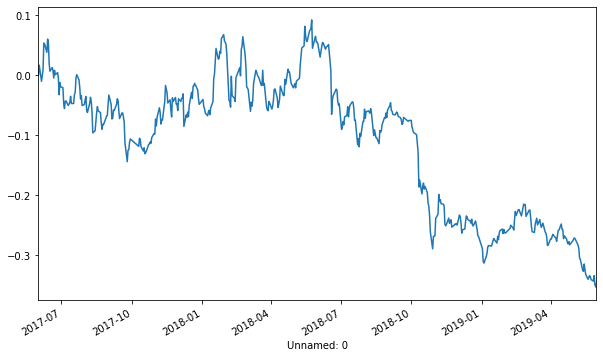

,PER,PER순위,기업명,구분,액면가(원),상장주식수(주),자본금(원)
A001470,0.11,1.0,삼부토건,코스피,1000,136140315,136140315000
A084110,0.62,3.0,휴온스글로벌,코스닥,500,10921362,5460681000
A032940,0.86,4.0,원익,코스닥,500,17934432,8967216000
A101000,1.09,5.0,상상인인더스트리,코스닥,500,42266042,21133021000
A003080,1.51,6.0,성보화학,코스피,500,20020000,10010000000
A005960,1.58,7.0,동부건설,코스피,5000,20882484,105541080000
A000230,1.72,8.0,일동홀딩스,코스피,1000,11002587,11002587000
A030530,2.24,9.0,원익홀딩스,코스닥,500,77237981,38618990500
A155900,2.36,10.0,바다로19호,코스피,5000,15200004,76000020000
A081660,2.48,11.0,휠라코리아,코스피,1000,61115070,61674420000


In [9]:
strategy_date = '2016/12'
start_date = '2017-6'
end_date = '2019-5'
initial_money = 100000000

low_per = get_value_rank(select_code_by_price(price_df, invest_df, start_date), 'PER', strategy_date, 200)
low_per_company = add_company_info(low_per, companies)
low_per_company_filter = get_price_over_list(low_per_company, 500)

per_backtest = backtest_with_code_list(price_df, low_per_company_filter.index[:5], start_date, end_date, initial_money)
#  [코드 5.18] 저per 백테스트 결과 그래프 그리기 (Ch5. 백테스트.ipynb)

plt.figure(figsize=(10, 6))
per_backtest['총변화율'].plot()
plt.show()

low_per_company_filter

In [59]:
companies.loc[low_per_company_filter.index[:5]]

,기업명,구분,액면가(원),상장주식수(주),자본금(원)
A001470,삼부토건,코스피,1000,136140315,136140315000
A084110,휴온스글로벌,코스닥,500,10921362,5460681000
A032940,원익,코스닥,500,17934432,8967216000
A101000,상상인인더스트리,코스닥,500,42266042,21133021000
A003080,성보화학,코스피,500,20020000,10010000000


In [10]:
#  [코드 5.17] 저per 포트폴리오 백테스트 (Ch5. 백테스트.ipynb)

strategy_date = '2015/12'
start_date = '2016-6'
end_date = '2017-5'
initial_money = 100000000

low_per = get_value_rank(select_code_by_price(price_df, invest_df, start_date), 'PER', strategy_date, 20)
per_backtest = backtest_beta(price_df, low_per, start_date, end_date, initial_money)

/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:321: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


In [18]:
per_backtest


,주식포트폴리오,현금포트폴리오,종합포트폴리오,일변화율,총변화율
Unnamed: 0,,,,,
2016-06-01,99772224.0,227776.0,100000000.0,NaN,0.000000
2016-06-02,100089062.0,227776.0,100316838.0,0.003168,0.003168
2016-06-03,100114264.0,227776.0,100342040.0,0.000251,0.003420
2016-06-07,101029929.0,227776.0,101257705.0,0.009125,0.012577
2016-06-08,101506684.0,227776.0,101734460.0,0.004708,0.017345
2016-06-09,101396336.0,227776.0,101624112.0,-0.001085,0.016241
2016-06-10,101606750.0,227776.0,101834526.0,0.002071,0.018345
2016-06-13,99774840.0,227776.0,100002616.0,-0.017989,0.000026
2016-06-14,99942657.0,227776.0,100170433.0,0.001678,0.001704


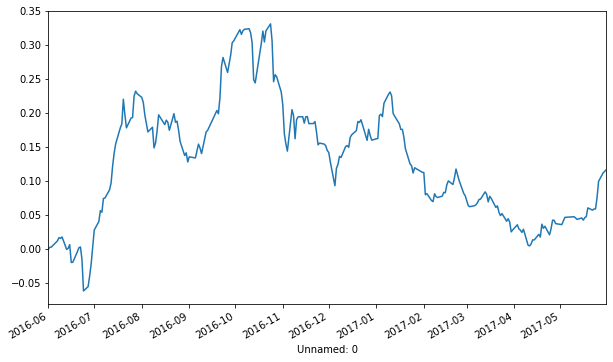

In [11]:
#  [코드 5.18] 저per 백테스트 결과 그래프 그리기 (Ch5. 백테스트.ipynb)

plt.figure(figsize=(10, 6))
per_backtest['총변화율'].plot()
plt.show()

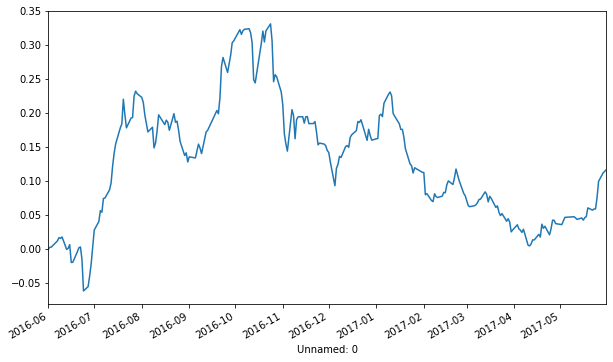

In [12]:
#  [코드 5.18] 저per 백테스트 결과 그래프 그리기 (Ch5. 백테스트.ipynb)

plt.figure(figsize=(10, 6))
per_backtest['총변화율'].plot()
plt.show()

In [45]:
price_df
price_df.iloc[-1]
price_df['2018/9'].iloc[0]
first_price = price_df['2018/9'].iloc[0]
last_price = price_df.iloc[-1]
price_diff = last_price - first_price

price_df.iloc[-1][price_diff > first_price/5]
price_diff
temp_df = pd.DataFrame({'diff':price_diff})
temp_df = temp_df[temp_df['diff'] > 0]
temp_df.index = 'A' + temp_df.index
temp_df
add_company_info(temp_df, companies)

,diff,기업명,구분,액면가(원),상장주식수(주),자본금(원)
A282330,17000.0,BGF리테일,코스피,1000,17283906,17283906000
A011150,335.0,CJ씨푸드,코스피,500,35930773,18065386500
A016610,270.0,DB금융투자,코스피,5000,42446389,212231945000
A007070,3500.0,GS리테일,코스피,1000,77000000,77000000000
A119650,2890.0,KC코트렐,코스피,500,13000000,6500000000
A001940,450.0,KISCO홀딩스,코스피,1000,18476380,18476380000
A051900,18000.0,LG생활건강,코스피,5000,15618197,88589470000
A079550,350.0,LIG넥스원,코스피,5000,22000000,110000000000
A229640,1020.0,LS전선아시아,코스피,500,30624879,15312439500
A023150,590.0,MH에탄올,코스피,500,7378526,4596763000


In [77]:
price_df
last_price = price_df.iloc[-1]
first_price = price_df['2018/9'].iloc[0]
temp_df = pd.DataFrame({last_price.name:last_price, first_price.name:first_price})
temp_df.index = 'A' + temp_df.index
temp_df['diff'] = temp_df[last_price.name] - temp_df[first_price.name]
temp_df = temp_df[temp_df[last_price.name] > 5000]
temp_df = temp_df[temp_df['diff'] > 0]
temp_df['ratio'] = temp_df['diff'] / temp_df[first_price.name]
temp_df = temp_df.sort_values(by='ratio', ascending=False)
price_diff_df = add_company_info(temp_df, companies)
get_kospi_list(price_diff_df)
# temp_df
# temp_df = temp_df[temp_df['ratio'] > 0.25]
# temp_df

# price_df['2018/9'].iloc[0]
# first_price = price_df['2018/9'].iloc[0]
# last_price = price_df.iloc[-1]
# price_diff = last_price - first_price

# price_df.iloc[-1][price_diff > first_price/5]
# price_diff
# temp_df = pd.DataFrame({'diff':price_diff})
# temp_df = temp_df[temp_df['diff'] > 0]
# temp_df.index = 'A' + temp_df.index
# temp_df
# add_company_info(temp_df, companies)

,2019-10-11 00:00:00,2018-09-03 00:00:00,diff,ratio,기업명,구분,액면가(원),상장주식수(주),자본금(원)
A002070,16100.0,7020.0,9080.0,1.293447,남영비비안,코스피,1000,6867945,6867945000
A009190,11300.0,5140.0,6160.0,1.198444,대양금속,코스피,500,12317933,6158966500
A004800,83400.0,45500.0,37900.0,0.832967,효성,코스피,5000,21071025,105355125000
A119650,6800.0,3910.0,2890.0,0.739130,KC코트렐,코스피,500,13000000,6500000000
A180640,30000.0,17800.0,12200.0,0.685393,한진칼,코스피,2500,59170458,149268060000
A286940,45400.0,27950.0,17450.0,0.624329,롯데정보통신,코스피,5000,15396331,76981655000
A012450,41300.0,25600.0,15700.0,0.613281,한화에어로스페이스,코스피,5000,51560000,265650000000
A000080,27150.0,16900.0,10250.0,0.606509,하이트진로,코스피,5000,70133611,368818745000
A001070,19000.0,12000.0,7000.0,0.583333,대한방직,코스피,1000,5300000,5300000000
A064960,48000.0,31300.0,16700.0,0.533546,S&T모티브,코스피,5000,14623136,73115680000
